# Model Evaluation
---

This notebook will demonstrate the evaluation of the models

## 1. Importing libraries

In [1]:
# Import libraries
import sys
import random
import numpy as np
import torch
import torchio as tio

sys.path.append("..")

from src.preprocessing import get_transforms, get_datasets, get_dataloaders, add_vessel_contrast
# from src.config import config
from src.drr import create_drr
from src.vizualization import plot_results, plot_drr_enhancement
import src.training

import torch
import matplotlib.pyplot as plt
from diffdrr.visualization import plot_drr, plot_mask

import torch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from diffdrr.drr import DRR
from diffdrr.data import read, transform_hu_to_density

from diffdrr.pose import convert
from diffdrr.visualization import drr_to_mesh, img_to_mesh
import pyvista

from tqdm import tqdm

from src.model import TACEnet
from monai.losses import DiceCELoss
from timeit import default_timer as timer
import numpy as np
import torchvision.transforms as tf
from torchvision import transforms

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Evaluate the non-deformation model

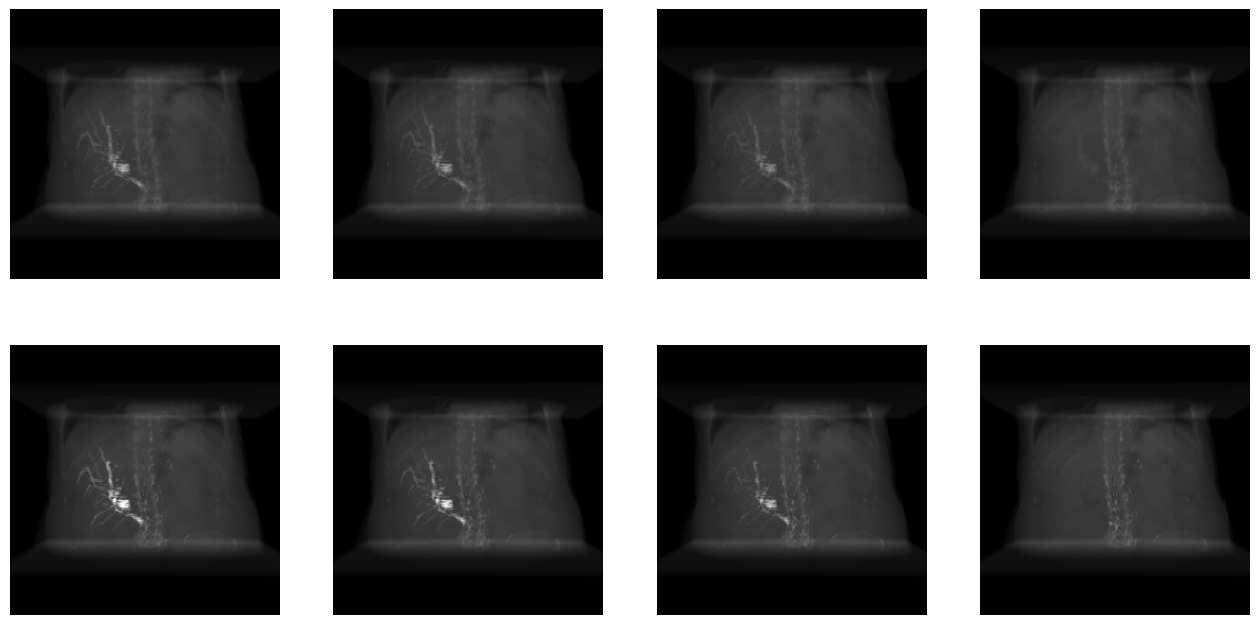

[0.6111773961490939, 0.5983437550987105, 0.5211740984848688, 0.33544345249300705, 0.15924259249931083, 0.0754908252774726, 0.05951922110160694, 0.08734356488911317, 0.14783748195385443, 0.2348085825598787]


In [2]:
loss = src.training.fetchResults('../models/TACEnet_vessel_enhancement_29052024.pth')
print(loss)

## 3. Evaluate the deformation model

In [3]:
# Get transforms
transform = get_transforms(resize_shape= [512, 512, 96], contrast_value=1000)

# Get datasets
train_ds, val_ds = get_datasets(
    root_dir="../data081",
    collection="HCC-TACE-Seg",
    transform=transform,
    download=False,
    val_frac=0.0,
    download_len=1,
    seed=42
)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Check length of datasets to make sure data split is correct
print(train_ds.get_indices(), val_ds.get_indices())

# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

# Separate the image and segmentation from the batch
volumes, targets = batch["image"], batch["seg"]

print(volumes.shape, targets.shape)

volumes = add_vessel_contrast(volumes, targets, contrast_value=4000)

[0] []
torch.Size([1, 1, 512, 512, 96]) torch.Size([1, 1, 512, 512, 96])


In [4]:
# Define model
model = TACEnet()

# Move model to device
model.to(device)

# Initialize the criterion, DICE loss with cross entropy uses binary cross entropy when there are only two classes
criterion = torch.nn.MSELoss()

# Initialize the optimizer, use config to set hyperparameters
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)

model.load_state_dict(torch.load("../models/TACEnet_vessel_enhancement_deformations_06062024.pth"))

<All keys matched successfully>

In [5]:
model.eval()

losses = []
rotation = 0

for i in range(20):
                # Read the image and segmentation subject
        subject = read(
                tensor=volumes[0],
                label_tensor=targets[0],
                orientation="AP",
                bone_attenuation_multiplier=5.0,
                )

                # Create a RandomElasticDeformation transform
        deform = tio.RandomElasticDeformation(p=1.0, num_control_points=7, max_displacement=50)

                # Apply the transform to the subject
        deformed_subject = deform(subject)

        deformed_subject.density = transform_hu_to_density(
                deformed_subject.volume.data, 5.0
                )
                
                # Create raw DRR
        drr_raw = create_drr(
                deformed_subject,
                sdd=1020,
                height=256,
                width=256,
                rotations=torch.tensor([[rotation, 0.0, 0.0]]),
                translations=torch.tensor([[0.0, 850.0, 0.0]]),
                mask_to_channels=True,
                device="cpu",
                )

                # Extract DRR body and vessels
        drr_body = drr_raw[:, 0]
        drr_vessels = drr_raw[:, 1]

                # Combine DRR body and vessels with enhancement factors
        ef = 0.6
        drr_combined_low_enhancement = (drr_body + ef * drr_vessels).unsqueeze(0)
        
                # Move tensors to the appropriate device
        drr_combined_low_enhancement = drr_combined_low_enhancement.to(device)
        drr_combined_target = drr_vessels.to(device)

                # Forward pass
        prediction, latent_representation = model(targets.to(device), drr_combined_low_enhancement)

                # Compute loss
        loss = criterion(prediction, drr_combined_target)

                

        # Plot the images (optional)
        #plot_results(drr_combined_low_enhancement, drr_combined_target, prediction, latent_representation, vmax=25)

        losses.append(loss.item())


c:\Users\Sven\anaconda3\envs\torch\Lib\site-packages\torchio\transforms\augmentation\spatial\random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
c:\Users\Sven\anaconda3\envs\torch\Lib\site-packages\torch\_tensor.py:1418: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


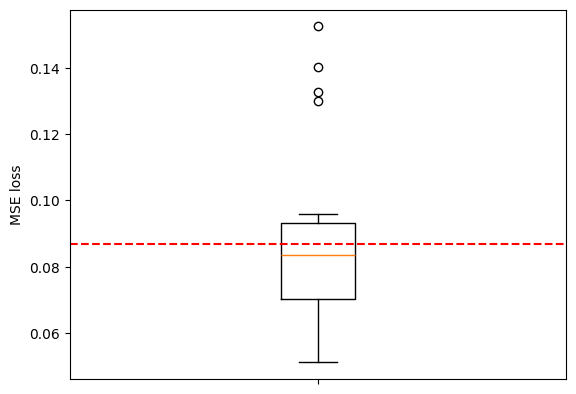

In [6]:
plt.boxplot(losses)
plt.ylabel('MSE loss')
# Set custom x-axis labels
plt.xticks([1], [''])
plt.axhline(y=0.08690, color='r', linestyle='--')

In [7]:
np.mean(losses)

0.0896688874810934

## 4. Evaluate the inference speed

### 4.1 3D speed

In [8]:
model = src.model.TACEnet().to('cuda')
input1 = torch.rand([1,1,512,512,96]).to('cuda')
input2 = torch.rand([1,1,256,256]).to('cuda')

start = timer()
output, _ = model(input1,input2)
end = timer()

print(end-start)

0.001203799998620525


### 4.2 2D speed

In [9]:
model = src.model.ConvNet().to('cuda')
array = np.random.randint(0, 1, size=(256,256,2))
transform = tf.ToTensor()


start = timer()
input = transform(array).to('cuda').float().unsqueeze(0)
output = model(input)
end = timer()

print(end-start)

0.00141789999906905
